# Workshop: Assumptions, Diagnostics and Transformations


## Diagnostic Plots

### Hidden Standard Plots
Generally speaking, the standard plots created by `R` when calling `plot(mod)` are all that you need to assess a linear model. In the accompanying lesson, we saw the standard 4 plots created with this method. However, there are actually *two* hidden plots available as well. To begin with, we will create our usual example regression model

In [1]:
data(mtcars)
mod <- lm(mpg ~ wt + hp + cyl, data=mtcars)

We will then create the two hidden plots and explain what they show. We start by calling `plot()` with the argument `which=4`

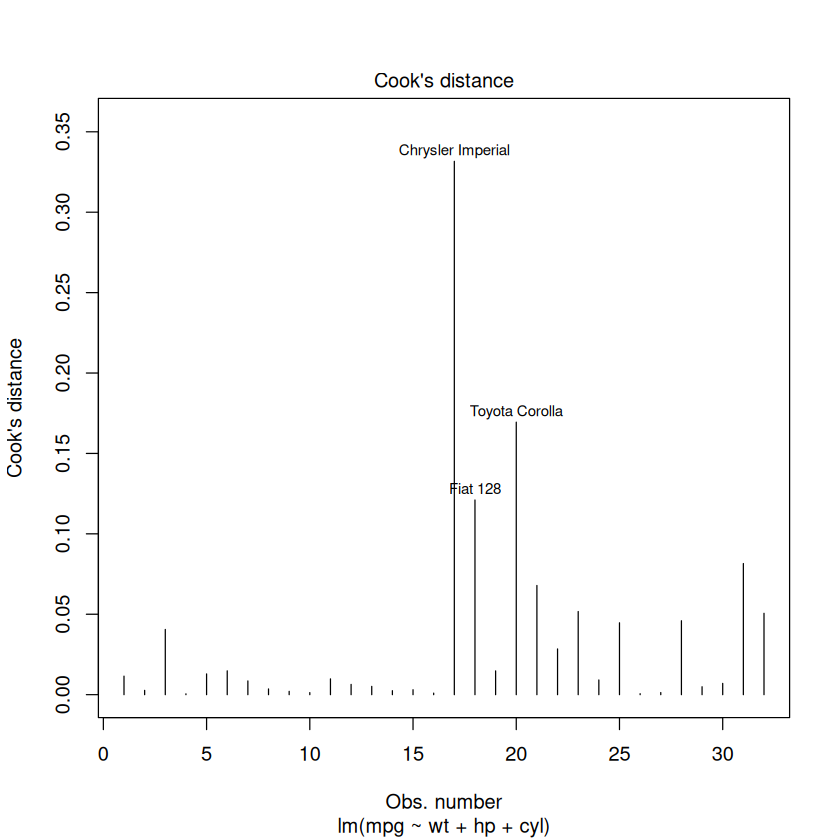

In [2]:
plot(mod, which=4)

This is very simply a plot of Cook's Distance for each observation. Remember from the lesson that Cook's Distance combines both the *studentised residuals* and *leverage* to indicate whether an observation is an outlier in *both* outcome and predictor space. There we indicated that $D > 0.5$ was a worry and $D > 1$ was a definite cause for concern. Unfortunately, the axis limits are hard-coded into the plotting function for `lm()`, so we cannot adjust the plot to show the current scale relative to these cut-offs. Nevertheless, notice that the *top* of the $y$-axis is 0.35, which is quite far away from 0.5 and from 1.

<div class="alert alert-block alert-info"> 
<b>ACTIVITY ...</b> Given that there are no concerning values of Cook's Distance here, why has <code>R</code> labelled three of the observations? What do these labels mean? <b>HINT</b> Refer back to the lesson if you cannot remember.
</div>

The next hidden plot can be created by calling `plot()` with the argument `which=6`

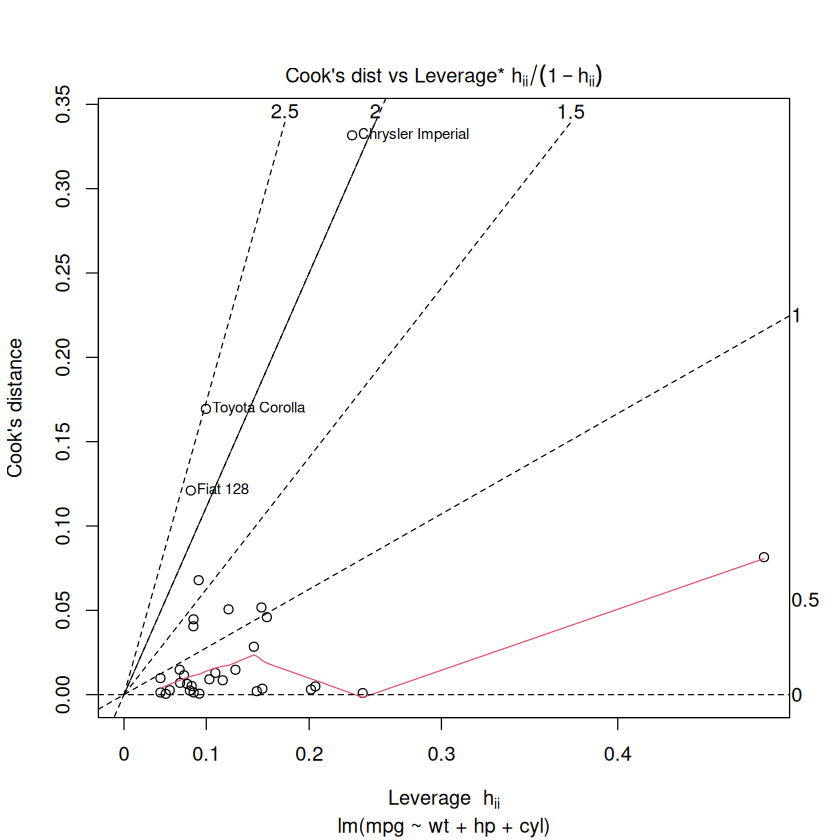

In [3]:
plot(mod, which=6)

Now, this plot is a funny one because it is quite complicated to understand, is not actually very useful and is almost never seen in practice. There is a good reason why it is hidden, though why it is included remains a mystery for the `R` development team. 

In brief, this plot shows *leverage* on the $x$-axis and *Cook's Distance* on the $y$-axis. The *dotted* straight lines correspond to values of Cook's Distance for a given value of leverage (on the $x$-axis) and a fixed value for the standardised residuals (the line label). For instance, the line labelled `1.5` shows us how increasing leverage corresponds to increasing Cook's Distance, if we fix a residual at a standardised value of 1.5. To understand this, it may help to look back at the formula for Cook's Distance and see how you could calculate different values for $D_{i}$ by *fixing* $t_{i} = 1.5$ and then varying the *leverage* from 0 to 0.5. This will give you the straight line in the plot. 

So how do we interpret this? Well, if a point lies *above* a given line (say the 1.5 line), it tells us that, based on the leverage value and Cook's Distance for that point, the standardised residual is greater than 1.5. So we can solve for the value of the residual, based on Cook's Distance and the leverage. 

Why is this useful. Well...it is not really. We do not need to solve for the standardised residual as we can just calculate it! About the only useful thing you can get from this plot is a visual sense of how Cook's Distance, leverage and the standardised residual value all connect. For instance, looking at the 2.5 line, we can see that a high Cook's Distance can be returned from a very low leverage value *if* the standardised residual is large encough. So high Cook's Distance does not necessarily mean high leverage, it can just mean a big residual. Similarly, if we look at the 1 line, we can see that a low Cook's Distance can be returned from a higher leverage value, if the standardised residual is also low. So low Cook's Distance does not necessarily mean low leverage, it can just mean a small residual. Beyond this conceptual illustration, the plot is not very useful, hence why it is *hidden*.

<div class="alert alert-block alert-info"> 
<b>ACTIVITY ...</b> Why do the lines on this plot get steeper as the standardised residual value increases? How does this connect with the idea that Cook's Distance <i>balances</i> the influence of leverage (outliers in predictor space) and large standardised residuals (outliers in outcome space)?
</div>

### Additional Plots
As well as the standard (non-hidden) plots produced by calling `plot(mod)`, there are some additional plots that can be useful to see various assumptions or data features more clearly. Here, we will have a brief rundown of some of the more useful.

#### Correlation Plots
Although previously we indicated that assessing correlation between predictors is best served by the VIF, it can be useful at times to investigate correlation as part of the initial descriptive exploration of the data, prior to fitting any model. For that purpose, a correlation plot can be useful. In the example below, we use the `corrplot` package to visualise the entire `mtcars` dataset.

corrplot 0.95 loaded



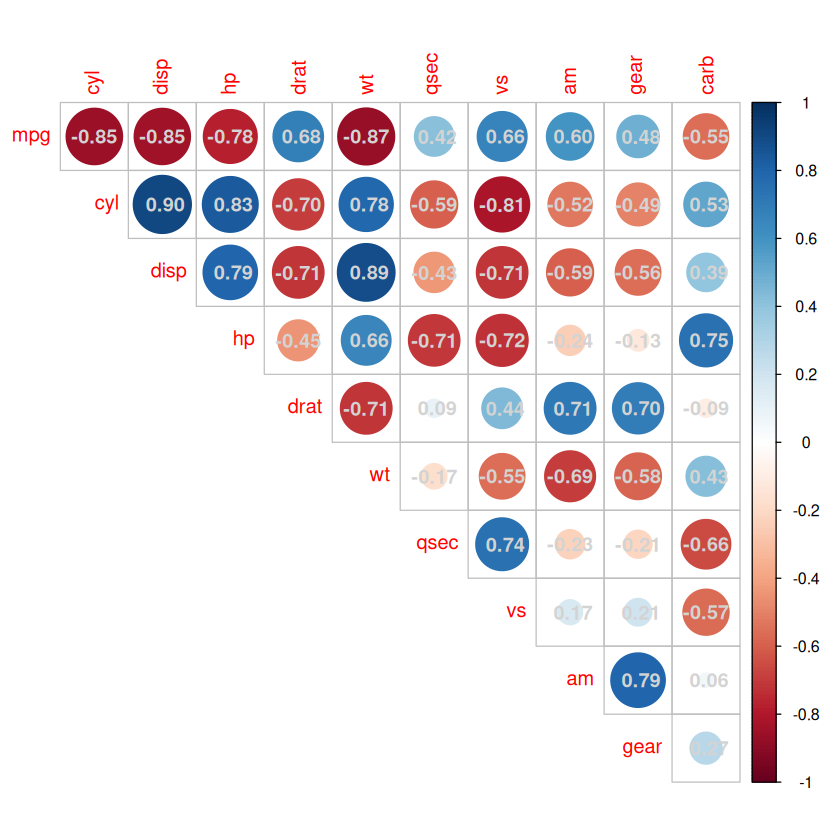

In [4]:
library('corrplot')
data(mtcars)
corrplot(cor(mtcars), 
        type='upper',            # just upper-diagonal
        addCoef.col='lightgrey', # add coeficient labels
        diag=FALSE)              # hide diagonal

<div class="alert alert-block alert-info"> 
<b>ACTIVITY ...</b> Have a look at all the options available by typing <code>?corrplot</code> and skimming through the documentation. Have a go at changing some of these.
</div>

Using the options specified in the original code above, there are several useful visual indicators here to alert us to problems. Firstly, the size of the circle is indicative of the magnitude of the correlation, so bigger circles are more of a warning than smaller circles. The *transparency* of the circles is also indicative of the magnitude, so this is a useful visual way of drawing our attention to larger correlations. Finally, the colour of the circles is indicative of the *direction* of the correlation, so that red shows *negative* and blue shows *positive*. 

<div class="alert alert-block alert-info"> 
<b>ACTIVITY ...</b> At the stage of trying to think about which <i>predictor variables</i> would be of most interest (when <code>mpg</code> is the outcome), which row/column should we be focussing on? Once we have some predictor variables, which rows/columns should we look at to decide whether multicollinearity might be a problem?
</div>

We can also see these relationships in terms of the actual data using a *pairs plot* 

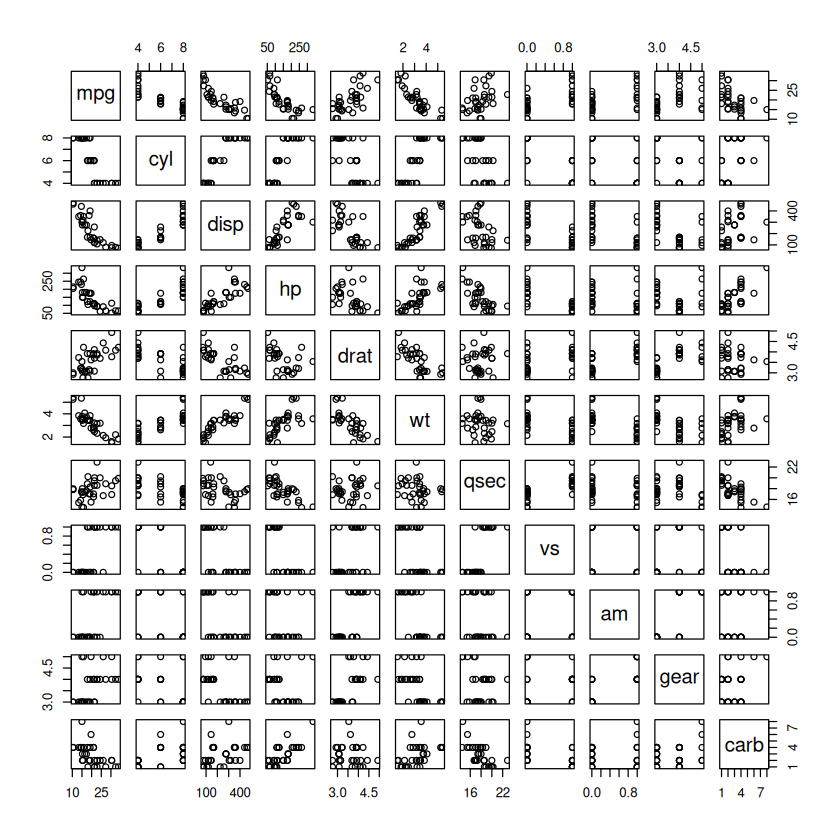

In [17]:
pairs(mtcars)

On its own, this will plot *everything* in the data frame, which can be difficult to see. We can be more specific by providing a formula, just like `lm()`

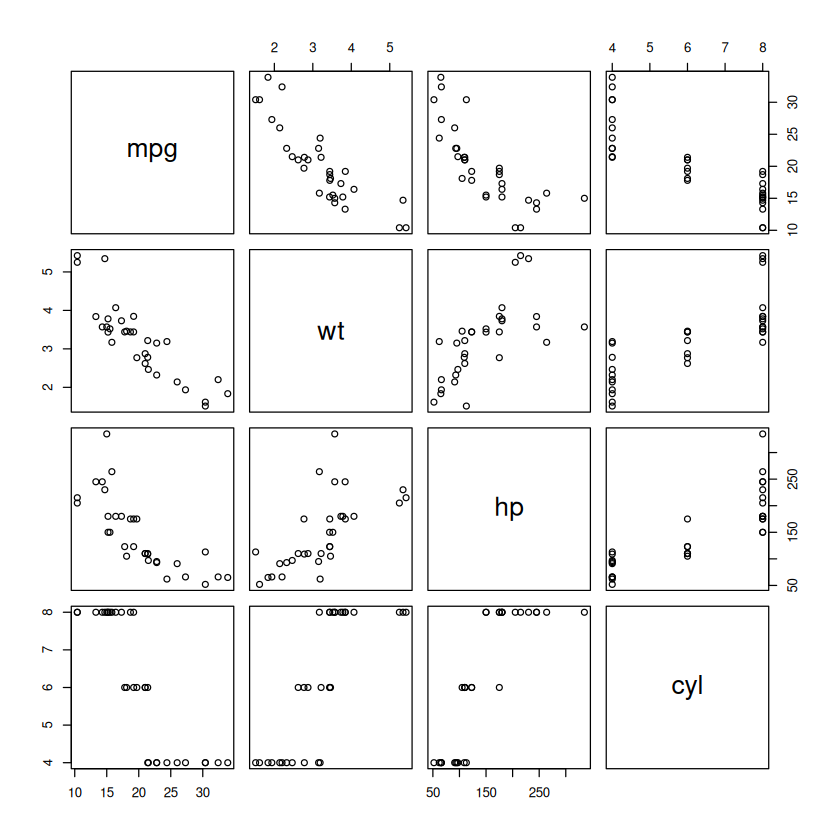

In [18]:
pairs(mpg ~ wt + hp + cyl, data=mtcars)

So now we can eye ball the relationships between the outcome and predictors, as well as the relationships *between* the predictors. Remember, these are not corrected for each other and so may not represent the result we would get from a multiple regression. This is more akin to multiple *simple* regression models.

#### VIF Barplot
As part of the accompanying lesson, we discussed the VIF and how to produce VIF values. However, it can be useful to visualise these as a bar chart with standard cut-offs of 5 and 10. In the example below, we include the same `wt.copy` variable as used in the lesson to simulate multicollinearity.

Loading required package: carData



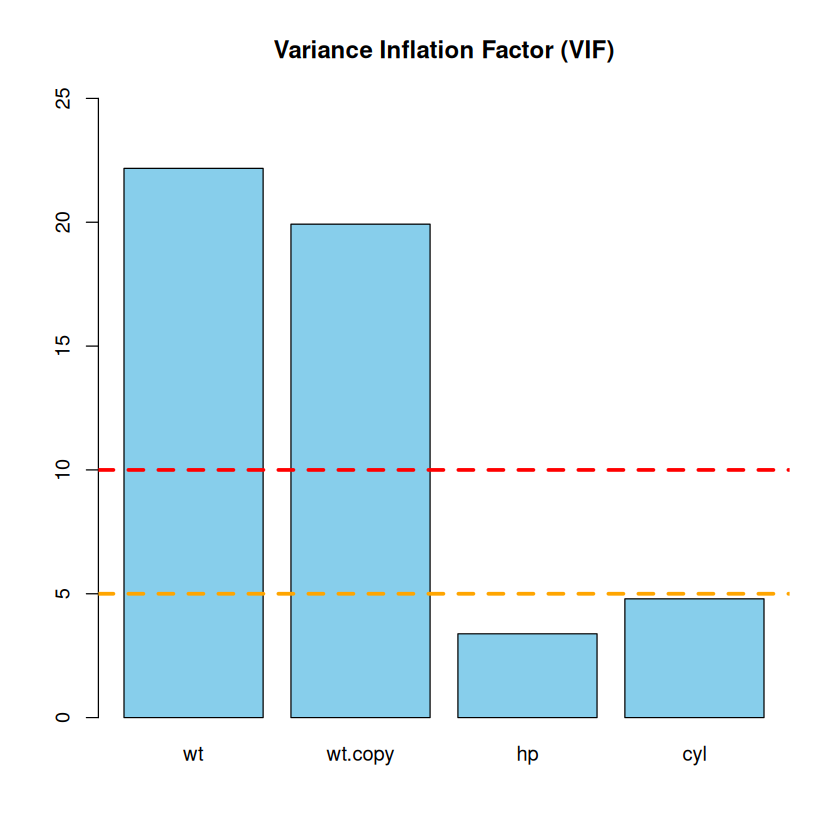

In [5]:
library(car)
set.seed(666)
wt           <- mtcars$wt
wt.copy      <- wt + rnorm(n=length(wt), mean=0, sd=0.2)        # wt + random noise
mod.multicol <- lm(mpg ~ wt + wt.copy + hp + cyl, data=mtcars)
vif.values   <- vif(mod.multicol)

barplot(vif.values, main="Variance Inflation Factor (VIF)", col="skyblue", ylim=c(0,25))
abline(h=5,  col="orange", lty=2, lwd=3)
abline(h=10, col="red",    lty=2, lwd=3)

<div class="alert alert-block alert-info"> 
<b>ACTIVITY ...</b> Use the code above to draw this chart again after removing <code>wt</code> from the model and then do this again after using <code>wt.copy</code> from the model. Keep the <code>ylim=c(0,25)</code> argument the same so you can directly compare the plots. Can we use VIF to tell us <i>which</i> predictor to remove from the model? What does this imply about the role of the analyst in the process of model building?
</div>

#### Influence Plot
Another useful plot included as part of the `car` package is the *influence* plot, where studentised residuals, leverage, Cook's distance and standard thresholds for extreme points are all combined into the same plot. As an example:

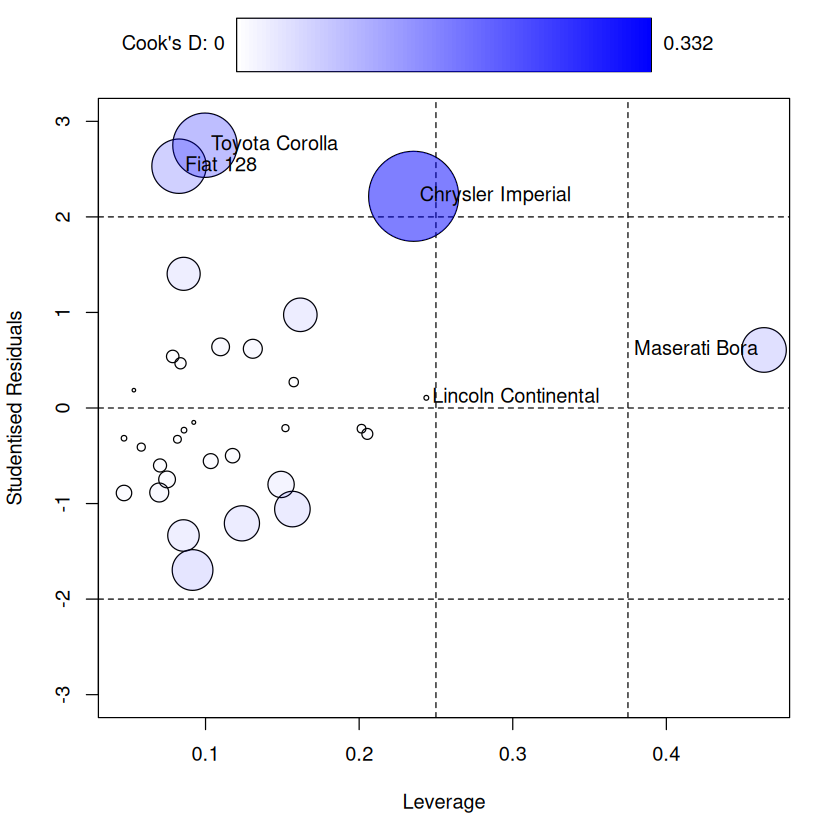

In [6]:
notable <- influencePlot(mod, xlab="Leverage", ylab="Studentised Residuals", ylim=c(-3,3))

Here we can see leverage plotted against the *studentised* resdiduals, with the magnitude of Cook's Distance displayed as bubbles of different sizes around each point. The mapping between these bubbles and Cook's Distance is shown by the colour bar at the top. Looking at the top value of the colourmap, we can see it is below our lower heuristic of $D > 0.5$, meaning we have little concern here in terms of Cook's distance. In addition, heuristics of 2 and -2 are shown vertically for outliers, with heuristics of $2\frac{p}{n}$ and $3\frac{p}{n}$ shown horizontally for leverage. Notable points have also been labelled and are returned as a data frame

In [7]:
print(notable)

                      StudRes        Hat        CookD
Lincoln Continental 0.1065775 0.24373270 0.0009486833
Chrysler Imperial   2.2153833 0.23547715 0.3316313326
Fiat 128            2.5303244 0.08274176 0.1210330843
Toyota Corolla      2.7498370 0.09961207 0.1694339333
Maserati Bora       0.6073374 0.46356582 0.0815260489


How these points are chosen requires a little explanation. The labels are based on the top two points for each of the influence measures. For the studentised residuals, the two largest points are `Toyota Corolla` and `Fiat 128`. For the leverage values, the two largest points are `Maserati Bora` and `Lincoln Continental`. For Cook's Distance, the two largest points are `Chrysler Imperial` and `Toyota Corolla`. So this gives five unique data points (because `Toyota Corolla` appears *twice*). The labelling in the plot can then be thought of as the two largest values horizontally, the two largest vertically, and the two largest in terms of their bubble size. Of note is that this will happen irrespective of whether any of the data points are above any threshold of concern on any measure. For instance, none of these data have $D_{i} > 0.5$, despite the function still labelling the top two values.

#### Manual Effects Plots
In the accompanying lesson, we discussed the use of effects plots as a useful alternative to added variable plots. Although the mechanics of effects was plots explained, it can be helpful to see how we could calculate these manually. Remember, rather than *removing* the influence of other variables, effects plots work by *fixing* the other variables to a constant value so that only the variable of interest changes. We can illustrate this using the `predict()` function in `R`. To begin with, we create a new dataset containing our predictors of interest. Here our focus is on the `wt` variable, so we keep this variable the raw as the raw data and fix `hp` and `cyl` to their *mean* value.

In [8]:
n       <- length(mtcars$mpg)
wt.data <- data.frame("wt" = mtcars$wt,             # raw wt
                      "hp" =rep(mean(mtcars$hp),n), # mean of hp
                      "cyl"=rep(mean(mtcars$cyl),n) # mean of cyl
                      )

print(head(wt.data)) # print the first 6 obersvations

     wt       hp    cyl
1 2.620 146.6875 6.1875
2 2.875 146.6875 6.1875
3 2.320 146.6875 6.1875
4 3.215 146.6875 6.1875
5 3.440 146.6875 6.1875
6 3.460 146.6875 6.1875


We can now pass this new data frame to the `predict()` function, which will use the parameter estimates from the model and apply the regression equation to each row of values in the new data set. This will create a set of *predictions* from the model. Because the only element that varies is `wt`, these predictions will correspond to the regression slope for `wt`, holding everything else constant. We can see that when we plot the values returned by `predict()`.

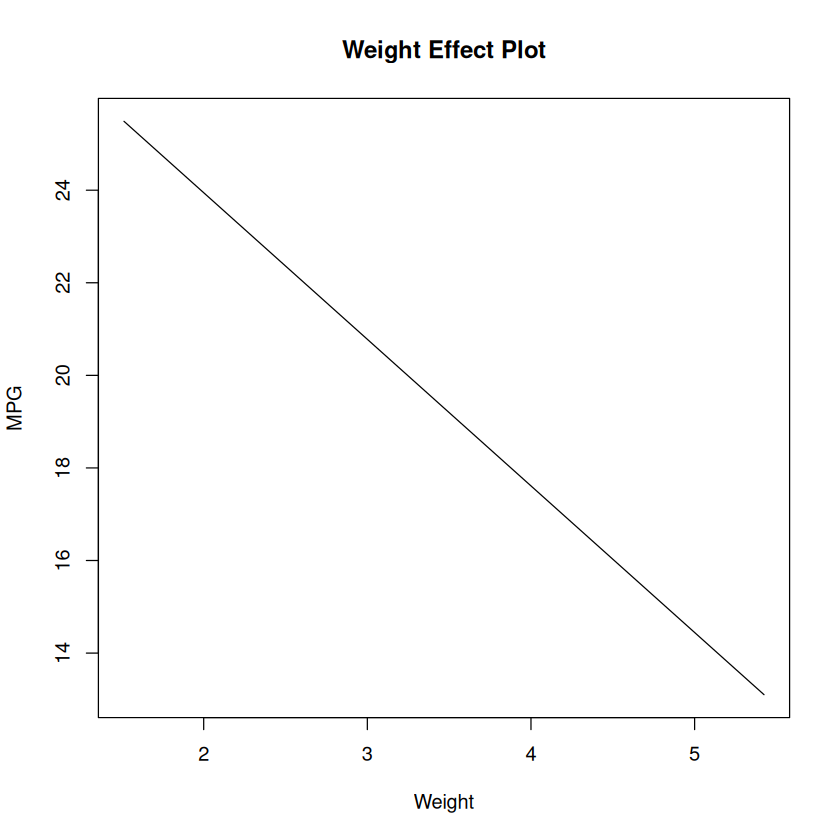

In [9]:
wt.effect <- predict(object=mod, newdata=wt.data) # b0 + b1*wt + b2*hp + b3*cyl
plot(mtcars$wt, wt.effect, type="l", xlab="Weight", ylab="MPG", main="Weight Effect Plot")

<div class="alert alert-block alert-info"> 
<b>ACTIVITY ...</b> Can you get the same values for <code>wt.effect</code> without using <code>predict</code>? <b>HINT</b> If you first extract the estimated regression parameters to a variable called <code>beta</code>, you can do this in a single line of code.
</div>

As we can see, this is the same as the effect plot for `wt`. Here we switch the confidence bands off to make the comparison clearer.

lattice theme set by effectsTheme()
See ?effectsTheme for details.



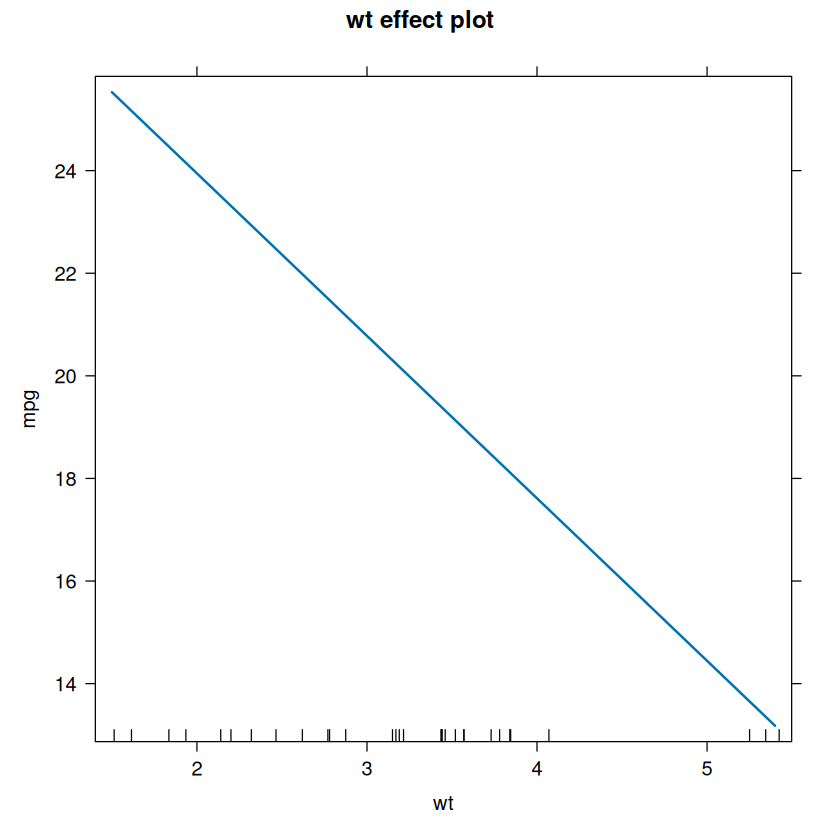

In [10]:
library(effects)
plot(effect('wt', mod, confidence.level=0))

<div class="alert alert-block alert-info"> 
<b>ACTIVITY ...</b> What happens if you use a constant value other than the mean? How does the plot change for a fixed value of 0 or some other value of <code>hp</code> or <code>cyl</code>? How does this change the interpretation?
</div>

We can also manually create the plot that includes the residuals by using the following

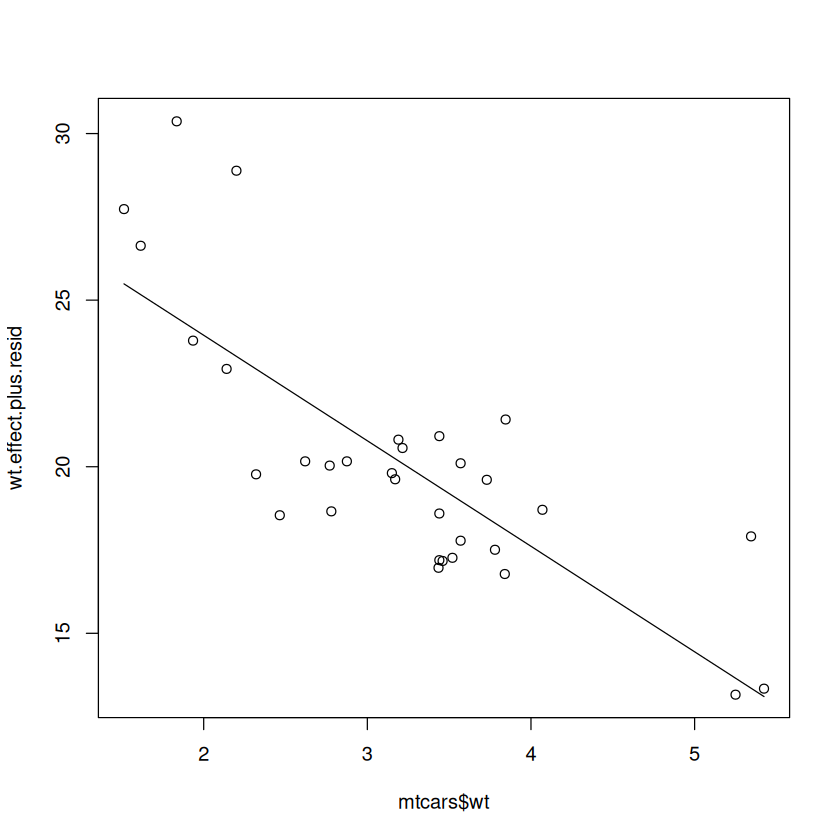

In [11]:
wt.effect.plus.resid <- wt.effect + resid(mod)
plot(mtcars$wt,  wt.effect.plus.resid)
lines(mtcars$wt, wt.effect)

which also agrees with what we get from the `effects` package, which we can see below. Again, we remove the confidence bands and the smoothed line through the points to make the comparison clearer.

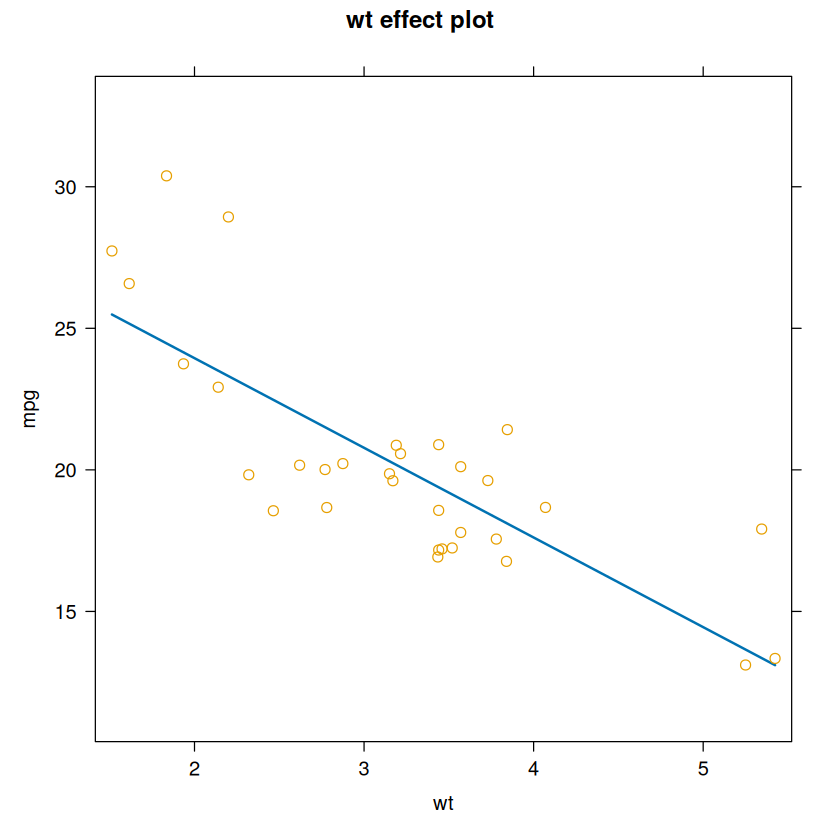

In [12]:
plot(effect('wt', mod, confidence.level=0, residuals=TRUE), partial.residuals=list(smooth=FALSE))

## Polynomial Regression
In thes accompanying lesson, we introduced polynomial regression as a solution when a straight-line did not appear to fit the data well. This is one of the most powerful options available to you to allow much more complex relationships between variables to be captured within a regression framework. In the lesson, we made use of the `poly()` function, but it is worth spending a little more time understanding *why* this was used. 

### Including Different Powers Directly
To illustrate why we use the `poly()` function, we will first start with a basic polynomial model of `wt`. For the sake of argument, we will say that through our diagnostic investigations we have decided that a polynomial of degree 2 would be a good idea (also known as a *quadratic* polynomial). The theoretical model for this would be

$$
y_{i} = \beta_{0} + \beta_{1}x_{i} + \beta_{2}x^{2}_{i} + \epsilon_{i}.
$$

So, it looks like we can just enter `wt` and `wt^2` into the model formula and be done. However, there are two issues with this. The first is a purely implementation `R`-specific issue, and the second is much more general.

In terms of the first issue, to include transformations directly in an `R` formula, we need to use the `I()` function, which tells `R` to treat whatever is inside the brackets literally. This is needed because many common symbols have special meanings inside an `R` formula. So this function can be taken to mean *Inhibit* the formula interpretation. For example, `*` usually means *multiply*, but inside an `R` formula it means something else (as we will see later in the ANOVA lesson). If we want `*` to still mean *multiply* within a formula, we have to use `I()`. This can be thought of as *inhibit interpreting this bit as a formula*. Similarly, if we want to raise a variable to a certain power, we would normally use

In [13]:
print(mtcars$wt^2)

 [1]  6.864400  8.265625  5.382400 10.336225 11.833600 11.971600 12.744900
 [8] 10.176100  9.922500 11.833600 11.833600 16.564900 13.912900 14.288400
[15] 27.562500 29.419776 28.569025  4.840000  2.608225  3.367225  6.076225
[22] 12.390400 11.799225 14.745600 14.784025  3.744225  4.579600  2.289169
[29] 10.048900  7.672900 12.744900  7.728400


However, the `^` symbol means something else inside an `R` formula. If we try it, notice it does not do what we expect

In [14]:
poly.mod <- lm(mpg ~ wt + wt^2, data=mtcars)
summary(poly.mod)


Call:
lm(formula = mpg ~ wt + wt^2, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5432 -2.3647 -0.1252  1.4096  6.8727 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  37.2851     1.8776  19.858  < 2e-16 ***
wt           -5.3445     0.5591  -9.559 1.29e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.046 on 30 degrees of freedom
Multiple R-squared:  0.7528,	Adjusted R-squared:  0.7446 
F-statistic: 91.38 on 1 and 30 DF,  p-value: 1.294e-10


Instead, we need to wrap this inside `I()` to tell `R` that we mean *treat this symbol as its usual meaning, not the special formula meaning*. For example

In [15]:
poly.mod <- lm(mpg ~ wt + I(wt^2), data=mtcars)
summary(poly.mod)


Call:
lm(formula = mpg ~ wt + I(wt^2), data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-3.483 -1.998 -0.773  1.462  6.238 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  49.9308     4.2113  11.856 1.21e-12 ***
wt          -13.3803     2.5140  -5.322 1.04e-05 ***
I(wt^2)       1.1711     0.3594   3.258  0.00286 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.651 on 29 degrees of freedom
Multiple R-squared:  0.8191,	Adjusted R-squared:  0.8066 
F-statistic: 65.64 on 2 and 29 DF,  p-value: 1.715e-11


This solves our first problem. In terms of the second problem, let us have a look at the VIF values

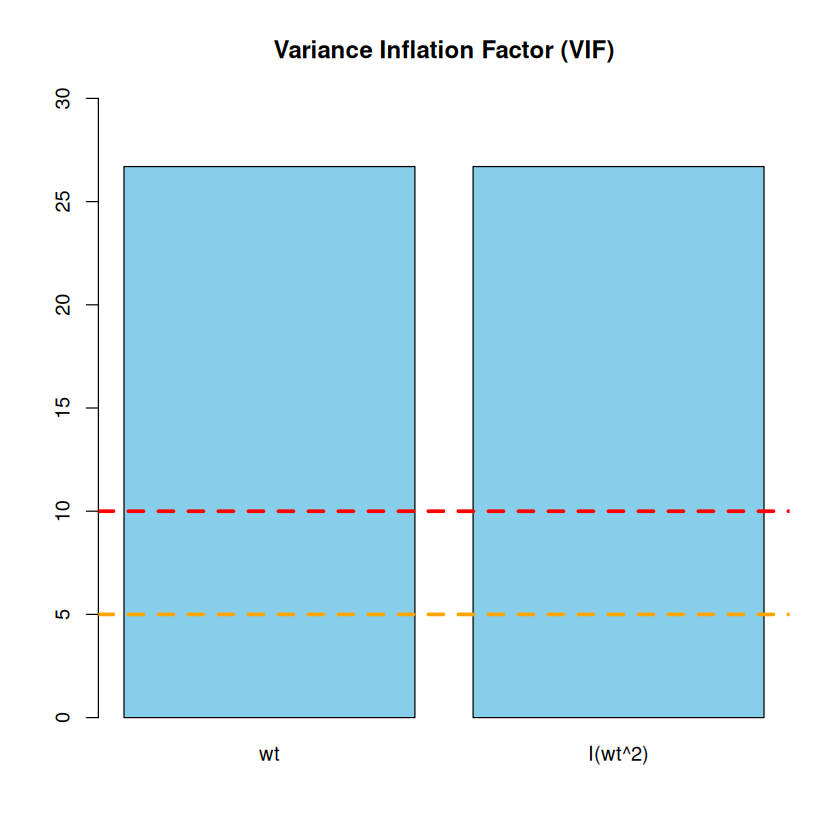

In [16]:
vif.values <- vif(poly.mod)
barplot(vif.values, main="Variance Inflation Factor (VIF)", col="skyblue", ylim=c(0,30))
abline(h=5,  col="orange", lty=2, lwd=3)
abline(h=10, col="red",    lty=2, lwd=3)

Ok, so now we can see the other issue. Including both `wt` and `wt^2` causes a massive multicollinearity problem.

<div class="alert alert-block alert-info"> 
<b>ACTIVITY ...</b> Before reading on, can you think what might be causing this result? Could you use some of the plots from earlier to investigate this further?
</div>

### Orthogonal Polynomials
Hopefully from the above it is clear that the problem is that when you raise a varible to any power it will remain *strongly correlated* with the original variable. This will then causes multicollinearity issues. The solution is that we need to use *orthogonal polynomials*, which is what the `poly()` function creates for us. In this context, *orthogonal* is taken to mean *uncorrelated*. As an example, we can rerun the model above using `poly()` and then check the VIF.

In [37]:
poly.mod <- lm(mpg ~ poly(wt,degree=2), data=mtcars)
summary(poly.mod)


Call:
lm(formula = mpg ~ poly(wt, degree = 2), data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-3.483 -1.998 -0.773  1.462  6.238 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            20.0906     0.4686  42.877  < 2e-16 ***
poly(wt, degree = 2)1 -29.1157     2.6506 -10.985 7.52e-12 ***
poly(wt, degree = 2)2   8.6358     2.6506   3.258  0.00286 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.651 on 29 degrees of freedom
Multiple R-squared:  0.8191,	Adjusted R-squared:  0.8066 
F-statistic: 65.64 on 2 and 29 DF,  p-value: 1.715e-11


Unfortunately, the `vif()` function from `car` gets a bit confused when we have `poly()` in the model formula, so we extract the predictors and add them manually to get the VIF values. This is usually unnecessary, so it should only be needed for this demonstration

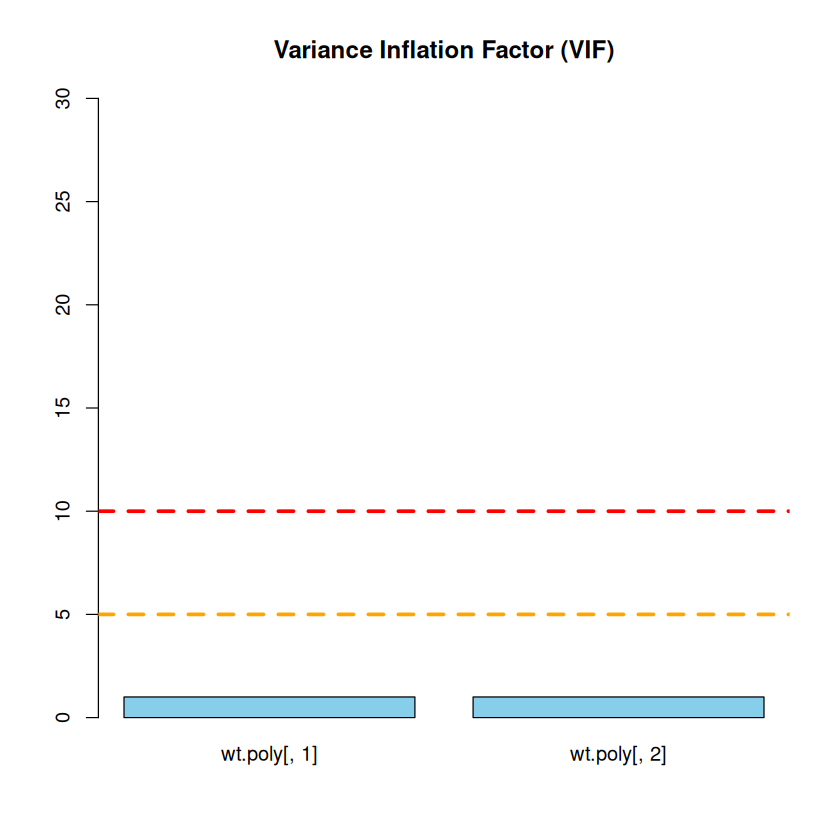

In [42]:
wt.poly      <- poly(mtcars$wt, degree=2)
poly.mod.alt <- lm(mpg ~ wt.poly[,1] + wt.poly[,2], data=mtcars)
vif.values   <- vif(poly.mod.alt)

barplot(vif.values, main="Variance Inflation Factor (VIF)", col="skyblue", ylim=c(0,30))
abline(h=5,  col="orange", lty=2, lwd=3)
abline(h=10, col="red",    lty=2, lwd=3)

As we can see, these predictors are *perfectly uncorrelated*. The VIF is 1 for each, meaning the variance is *not inflated at all* with these two predictors in the model. This is the essence of two variable being *orthogonal*. We can also see this by calculating their correlation as well

In [41]:
cor(wt.poly[,1],wt.poly[,2])

[1] 5.514184e-19

which is basically *exactly 0*, as far as the computer is concerned.

How is this done? In a way, it does not really matter, but if you are curious then the method is very similar to what we do when we create *added variable plots*. In effect, we just need to *remove* the relationship between the variable by taking the residuals of several regression models. An example is given below. For each term, we basically remove the effect of all *lower degree terms*. So the linear term has the constant effect removed, and the quadratic term has the constant and linear effects removed. The output from `lm()` is the identical in terms of fit, $t$-statistics and $p$-values when compared to the model using `poly()`.

In [43]:
wt.1 <- resid(lm(wt   ~ 1,    data=mtcars)) # wt   with constant effect removed
wt.2 <- resid(lm(wt^2 ~ wt.1, data=mtcars)) # wt^2 with constant + linear effect removed

summary(lm(mpg ~ wt.1 + wt.2, data=mtcars))


Call:
lm(formula = mpg ~ wt.1 + wt.2, data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-3.483 -1.998 -0.773  1.462  6.238 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.0906     0.4686  42.877  < 2e-16 ***
wt.1         -5.3445     0.4865 -10.985 7.52e-12 ***
wt.2          1.1711     0.3594   3.258  0.00286 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.651 on 29 degrees of freedom
Multiple R-squared:  0.8191,	Adjusted R-squared:  0.8066 
F-statistic: 65.64 on 2 and 29 DF,  p-value: 1.715e-11


There are just a couple of points to be aware of here. Firstly, `poly()` uses a different scaling to the result you get from regressing variables on each other, so the parameter estimates and standard errors will be different. Because of this, it is very difficult to interpret these effects in any precise numeric fashion. However, the way to think of them is as the *unique linear effect* and the *unique quadratic effect*. The tests of these effects can be taken as indications of whether the *quadratic component* is needed and whether the *linear component* is needed to provide a good model fit.

## Alternative Models When Assumptions are Violated
As a final part in this workshop, we will consider a different solution to assumption violations. Rather than trying to transform our way out of a hole, we instead consider a different *model* that is able to more flexibly accommodate a particular assumption violation.

### Robust Regression for Outliers

### Generalised Least-squares for Heteroscedasticity

### Ridge-regression for Multicollinearity

### Non-parametric Resampling for Non-normality

### What About Multiple Violations?
Finally, we need to consider what to do if *multiple* assumptions appear to be violated.